In [1]:
import os, sys
os.chdir(os.path.abspath('..'))

In [2]:
import json, pickle
import tqdm.notebook as tqdm

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
%load_ext autoreload
%autoreload 2

from src.vae_models import CVAE
import src.utils as utils
import src.preprocess_lib as preprocess_lib
import src.testing_lib as testing_lib
import src.experiment_lib as experiment_lib

In [4]:
sns.set_theme(style="whitegrid", font='serif')
sns.set_context("paper", font_scale=2.5)

In [5]:
config_dir = 'runs/sweep_runs_corrected'
config_file = 'config.json'

In [6]:
save_dir = 'transfer/test_results_viz'

In [7]:
df_experiment = experiment_lib.collect_results(config_dir, config_file)


In [8]:
df_experiment = experiment_lib.rename_columns(df_experiment)
df_experiment = experiment_lib.add_columns(df_experiment)

[{"variableName": "df_experiment", "type": "pandas", "supportedEngines": ["pandas"], "isLocalVariable": false}]
[{"variableName": "df_experiment", "type": "pandas", "supportedEngines": ["pandas"], "isLocalVariable": false}, {"variableName": "df_experiment_filtered", "type": "pandas", "supportedEngines": ["pandas"], "isLocalVariable": false}, {"variableName": "filter_arr", "type": "series", "supportedEngines": ["pandas"], "isLocalVariable": false}]
[{"variableName": "df_experiment", "type": "pandas", "supportedEngines": ["pandas"], "isLocalVariable": false}, {"variableName": "df_experiment_filtered", "type": "pandas", "supportedEngines": ["pandas"], "isLocalVariable": false}, {"variableName": "filter_arr", "type": "series", "supportedEngines": ["pandas"], "isLocalVariable": false}, {"variableName": "model_folders", "type": "ndarray", "supportedEngines": ["pandas"], "isLocalVariable": false}]
[{"variableName": "df_experiment", "type": "pandas", "supportedEngines": ["pandas"], "isLocalVar

In [9]:
filter_arr =    (df_experiment["Number of LDA Topics"] != None) & \
                (np.isin(df_experiment["Number of LDA Topics"], [100])) & \
                (df_experiment["Availability Rate (b)"] == 10) & \
                (df_experiment["Beta"] == 1.0) & \
                (df_experiment["Likelihood Distribution"] != None) & \
                (df_experiment["Number of LDA Clusters"] != None) & \
                (np.isin(df_experiment["Number of LDA Clusters"], [1000])) & \
                (df_experiment["Dropout"] == False) & \
                (df_experiment["Pattern Dictionary Size"] != None) & \
                (np.isin(df_experiment["Pattern Dictionary Size"], [0, 25, 50, 75, 100, 125, 150])) & \
                (df_experiment["data_random_seed"] == 2112) & \
                (df_experiment["epsilon"] == 1e-4)

In [10]:
df_experiment_filtered = df_experiment[filter_arr]
df_experiment_filtered = df_experiment_filtered.sort_values(by=["Pattern Dictionary Size"], ascending=True)
df_experiment_filtered

,data_random_seed,data_dataset_dir,data_dataset_name,data_test_ratio,data_val_ratio,data_resolution,data_pad,data_ampute_params_a,Availability Rate (b),data_subsample_rate_user,...,User-Informed,Expected Missing Days,Missing Set Size,Test Set Size,Validation Set Size,Training Set Size,Test Set Ratio,Validation Set Ratio,Missing Set Ratio,Training Set Ratio
26,2112,data,goi4_dp_full_Gipuzkoa,0.2,0.2,1,0,0.85,10,1,...,Yes,28.6,197674,459055.2,459055.2,1377165.6,0.184141,0.184141,0.079293,0.552424
19,2112,data,goi4_dp_full_Gipuzkoa,0.2,0.2,1,0,0.85,10,1,...,Yes,28.6,197674,459055.2,459055.2,1377165.6,0.184141,0.184141,0.079293,0.552424
43,2112,data,goi4_dp_full_Gipuzkoa,0.2,0.2,1,0,0.85,10,1,...,Yes,28.6,197674,459055.2,459055.2,1377165.6,0.184141,0.184141,0.079293,0.552424
101,2112,data,goi4_dp_full_Gipuzkoa,0.2,0.2,1,0,0.85,10,1,...,Yes,28.6,197674,459055.2,459055.2,1377165.6,0.184141,0.184141,0.079293,0.552424
41,2112,data,goi4_dp_full_Gipuzkoa,0.2,0.2,1,0,0.85,10,1,...,Yes,28.6,197674,459055.2,459055.2,1377165.6,0.184141,0.184141,0.079293,0.552424
9,2112,data,goi4_dp_full_Gipuzkoa,0.2,0.2,1,0,0.85,10,1,...,Yes,28.6,197674,459055.2,459055.2,1377165.6,0.184141,0.184141,0.079293,0.552424
102,2112,data,goi4_dp_full_Gipuzkoa,0.2,0.2,1,0,0.85,10,1,...,Yes,28.6,197674,459055.2,459055.2,1377165.6,0.184141,0.184141,0.079293,0.552424


In [11]:
model_folders = df_experiment_filtered["model_folder"].values

In [12]:
model_folders

array(['sweep_Sep13_06-36-58', 'sweep_Sep12_03-15-05',
       'sweep_Sep14_03-32-09', 'sweep_Sep14_05-06-02',
       'sweep_Sep13_07-57-26', 'sweep_Sep14_06-38-32',
       'sweep_Sep14_08-12-09'], dtype=object)

In [334]:
args ={
    "overwrite": False,
    "config_dir": 'runs/sweep_runs_corrected',
    "device": "cuda:1",
    "num_rec_samples": 100,
    "batch_size": 10000,
    "batch_size_mc": 50,
}

In [335]:
pbar = tqdm.tqdm(total=len(model_folders), dynamic_ncols=True)

for i, folder in enumerate(model_folders):

    pbar.update(1)
    pbar.write(f"Testing {folder} ({i+1}/{len(model_folders)})...")

    if not os.path.exists(os.path.join(config_dir, folder, "trained_model.pt")):
        pbar.write(f"Model file not found for {folder}. Skipping...")
        continue
    if not args["overwrite"]:
        if os.path.exists(os.path.join(args["config_dir"], folder, "test_results_ll_rll_kl.csv")) and os.path.exists(os.path.join(args["config_dir"], folder, "test_results_ll_rll_kl_aggregate.pkl")):
            pbar.write(f"Test results already exist for {folder}. Skipping...")
            continue
        
    # Load config file
    pbar.write(f"Loading config file for {folder}...")
    if not os.path.exists(os.path.join(args["config_dir"], folder, config_file)):
        pbar.write(f"Config file not found for {folder}. Skipping...")
        continue
    with open(os.path.join(args["config_dir"], folder, config_file), 'r') as f: config = json.load(f)
    
    ## Load the data
    # utils.blockPrint()
    trainset, valset, conditioner, user_ids, months, condition_set, X_test, X_missing, _, nonzero_mean, nonzero_std = preprocess_lib.prepare_data(config["data"])

    # Load model
    model = CVAE(input_dim=trainset.inputs.shape[1], conditioner=conditioner, **config["model"])
    model.load(os.path.join(args["config_dir"], folder))
    model.eval()
    # utils.enablePrint()
    
    #Prepare the datasets
    log_space = config["data"]["scaling"]["log_space"]
    zero_id = config["data"]["scaling"]["zero_id"]
    shift = config["data"]["scaling"]["shift"]
    
    pbar.write(f"Preparing datasets for {folder}...")

    inputs = {  "test": torch.tensor(X_test).float(),
                "missing": torch.tensor(utils.zero_preserved_log_normalize(X_missing*1.0, nonzero_mean, nonzero_std, log_output=log_space, zero_id=zero_id, shift=shift)).float()}
    
    results_raw, results_agg = {}, {}
    
    for set_type in ["test", "missing"]:
        results_raw[set_type], results_agg[set_type] = {}, {}

        x = inputs[set_type]
        conditions =  torch.tensor(conditioner.transform(condition_set[set_type].copy())).float()

        pbar.write(f"Calculating probabilistic metrics for {set_type}set while reconstructing...")
        loglikelihoods, rlls, kl_divergences = testing_lib.mass_loglikelihood(model, x, conditions, num_mc_samples=args["num_rec_samples"], batch_size=args["batch_size"], mc_sample_batch_size=args["batch_size_mc"], device=args["device"])
        rlls = rlls.mean(axis=0)

        df = pd.DataFrame({ "loglikelihood": loglikelihoods, 
                            "rll": rlls,
                            "kl": kl_divergences,
                            "user_id": user_ids[set_type], 
                            "month": months[set_type]})

        results_agg[set_type]["users"] = df.groupby("user_id").mean().values[:,0]
        results_agg[set_type]["months"] = df.groupby("month").mean().values[:,0]
        results_agg[set_type]["loglikelihood"] = loglikelihoods.mean().item()
        results_agg[set_type]["rll"] = rlls.mean().item()
        results_agg[set_type]["kl"] = kl_divergences.mean().item()

        results_raw[set_type] = df
        results_raw[set_type]["set_type"] = set_type


    pbar.write("Saving results...")
    results_concat = pd.concat([results_raw[set_type] for set_type in ["test", "missing"]])
    results_concat.to_csv(os.path.join(args["config_dir"], folder, "test_results_ll_rll_kl.csv"), index=False)

    with open(os.path.join(args["config_dir"], folder, "test_results_ll_rll_kl_aggregate.pkl"), 'wb') as f: pickle.dump(results_agg, f)

    pbar.write(f"Finished testing {folder} ({i+1}/{len(model_folders)})")

  0%|          | 0/7 [00:00<?, ?it/s]

In [336]:
df = pd.DataFrame()
for i, folder in enumerate(os.listdir(os.path.join(config_dir))):
    # Load config file
    with open(os.path.join(config_dir, folder, config_file), 'r') as f: config = json.load(f)
    config_flt = utils.flatten_dict(config)
    config_flt["model_folder"] = folder

    df_config_val = pd.DataFrame(config_flt, index=[i])

    # Load test results
    if not os.path.exists(os.path.join(config_dir, folder, 'test_results_ll_rll_kl_aggregate.pkl')): df_test = pd.DataFrame()
    else:
        with open(os.path.join(config_dir, folder, 'test_results_ll_rll_kl_aggregate.pkl'), 'rb') as f: test_results = pickle.load(f)
        test_results_flt = utils.flatten_dict(test_results)
        ##add to dataframe
        df_test = pd.DataFrame([test_results_flt], index=[i])

    df = pd.concat([df, pd.concat([df_config_val, df_test], axis=1)], axis=0)

In [337]:
df = experiment_lib.rename_columns(df)
df = experiment_lib.add_columns(df)

In [338]:
df.rename(columns={ 
                    'test_rll': 'RLL (Test)',
                    'missing_rll': 'RLL (Missing)',
                    'test_kl': 'KL-Div. (Test)',
                    'missing_kl': 'KL-Div. (Missing)',
                }, inplace=True)

In [339]:
df["-(KL-Div.) (Test)"] = -df["KL-Div. (Test)"]
df["-(KL-Div.) (Missing)"] = -df["KL-Div. (Missing)"]

In [340]:
df_experiment_filtered = df[filter_arr]
# df_experiment_filtered = df_experiment_filtered.drop(df_experiment_filtered[(df_experiment_filtered["epsilon"] != 1e-4) & (df_experiment_filtered["Pattern Dictionary Size"]==0)].index)
# df_experiment_filtered = df_experiment_filtered.melt(id_vars=["Pattern Dictionary Size"], var_name= "set", value_vars=['Log-Likelihood (Test)', 'Log-Likelihood (Missing)', 'RLL (Test)', 'RLL (Missing)', 'KL-Div. (Test)', 'KL-Div. (Missing)'])

In [341]:
test_cols = ['RLL (Test)', 'KL-Div. (Test)']
missing_cols = ['RLL (Missing)', 'KL-Div. (Missing)']

# Ensure the order of columns in val_cols and test_cols are aligned by metric (accuracy with accuracy, etc.)
metrics = [col.split(' ', 1)[0] for col in test_cols]  # Extract metric names

# Create the long format dataframe
df_long = pd.DataFrame({
    'Score': pd.concat([df_experiment_filtered[val] for val in missing_cols] + [df_experiment_filtered[test] for test in test_cols], ignore_index=True),
    'Set Type': ['missing'] * len(df_experiment_filtered) * len(missing_cols) + ['test'] * len(df_experiment_filtered) * len(test_cols),
    'Metric': np.tile(np.repeat(metrics, len(df_experiment_filtered)),2),
    'Pattern Dictionary Size': np.tile(df_experiment_filtered['Pattern Dictionary Size'].values, 2*len(missing_cols)),
    'User-Informed': np.tile(df_experiment_filtered['User-Informed'].values, 2*len(missing_cols))
})

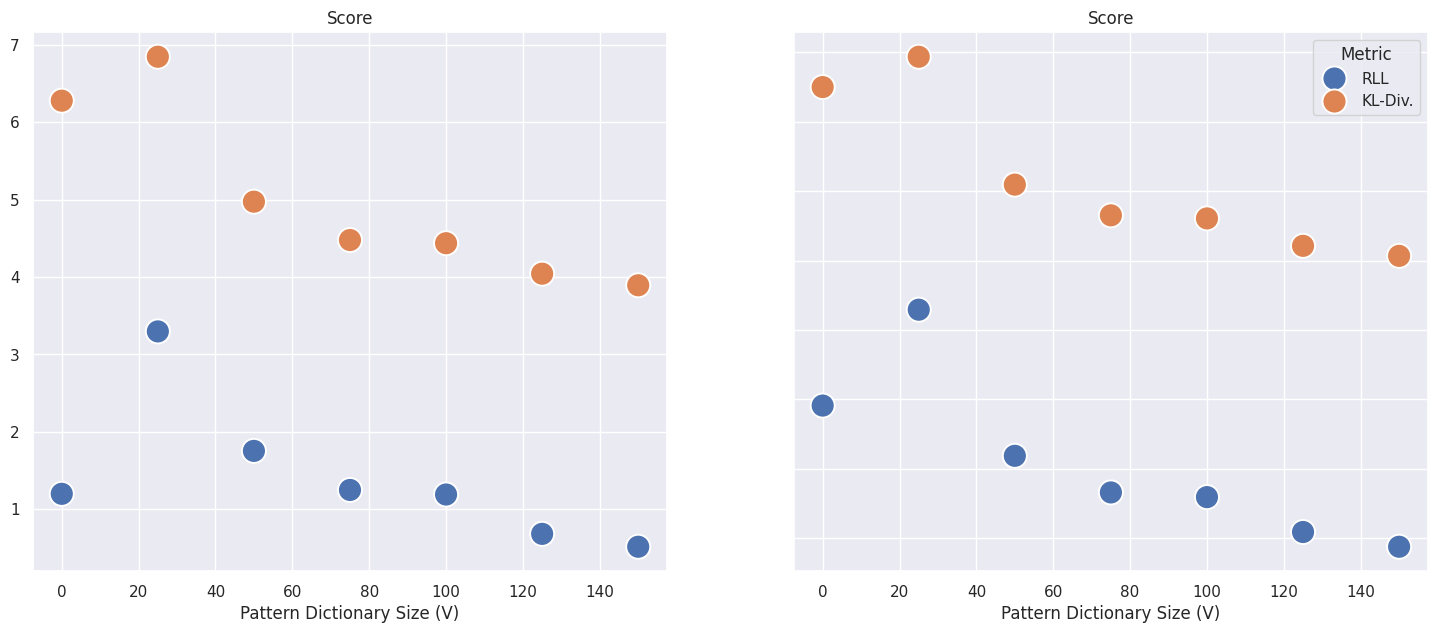

In [343]:
fig, ax = plt.subplots(1, 2, figsize=(20*0.9, 7*1.0))


h0 = sns.scatterplot(data=df_long[df_long["Set Type"] == 'test'],
                    y="Score",
                    x="Pattern Dictionary Size",
                    hue="Metric",
                    # style="User-Informed",
                    s=300,
                    ax=ax[0])

h1 = sns.scatterplot(data=df_long[df_long["Set Type"] == 'missing'],
                    y="Score",
                    x="Pattern Dictionary Size",
                    hue="Metric",
                    # style="User-Informed",
                    s=300,
                    ax=ax[1])

ax[0].set_title(ax[0].get_ylabel())
ax[1].set_title(ax[1].get_ylabel())

## share same y-axis
ax[0].set_ylabel('')
ax[1].set_ylabel('')

ax[0].set_xlabel('Pattern Dictionary Size (V)')
ax[1].set_xlabel('Pattern Dictionary Size (V)')

## remove y tick labels
ax[1].set_yticklabels([])


## same ylim for both plots
# ax[0].set_ylim(-10, -1.5)
# ax[1].set_ylim(-10, -1.5)

#remove legend
h0.legend_.remove()

if os.path.exists(save_dir):
    plt.savefig(os.path.join(save_dir, f'{relplot_kwargs["x"]}.png'), bbox_inches='tight', dpi=300)